# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn.mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
print(COCO_MODEL_PATH)
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

C:\Users\VCC\Desktop\Mask_RCNN\mask_rcnn_coco.h5


## Configurations

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 384

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8*6, 16*6, 32*6, 64*6, 128*6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
# config.display()

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):#--------------------改变默认的图片大小适应notebook的嵌入
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
# print(get_ax())

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [14]:
from PIL import Image
import yaml
import cv2
class QuiltDataset(utils.Dataset):
    
    def get_obj_index (self, image):
        n = np.max(image)
        return n
    #解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self,image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read())
            labels = temp['label_names']
            del labels[0]
        return labels
    #重新写draw_mask
    def draw_mask(self, num_obj, mask, image):
        info = self.image_info[image_id]
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    # print(str(i)+"---"+str(j))
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask
    #重新写load_shapes，里面包含自己的自己的类别（我的是box、column、package、fruit四类）
    #并在self.image_info信息中添加了path、mask_path 、yaml_path
    def load_shapes(self, count, img_floder, mask_floder, imglist,dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "head")
        self.add_class("shapes", 2, "quilt")
        self.add_class("shapes", 3, "corner")
        self.add_class("shapes", 4, "edge")
        for i in range(count):
            filestr = imglist[i].split(".")[0]
            mask_path = mask_floder + "/" + filestr + ".png"
            yaml_path = dataset_root_path+"labelme_json/rgb_"+str(i+1)+"_json/info.yaml"
            print(yaml_path)
            image_path = dataset_root_path + "pic/" + str(i+1) + ".png"
            cv_img = cv2.imread(image_path)
            # print(i)
            self.add_image("shape", image_id=i+1, path=img_floder + "/" + imglist[i],
                           width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)
            # print(self.image_info)
    #重写load_mask
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        info = self.image_info[image_id]
        
        count = 1  # number of object
        # print("mask_path:"+info['mask_path'])
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        # print(type(img))
        # print(mask.shape)
        mask = self.draw_mask(num_obj, mask, img)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels=[]
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("edge") != -1:
                labels_form.append("edge")
            elif labels[i].find("quilt") != -1:
                labels_form.append("quilt")
            elif labels[i].find("corner") != -1:
                labels_form.append("corner")
            elif labels[i].find("head") != -1:
                labels_form.append("head")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)


In [17]:
#基础设置
dataset_root_path = "C:/Users/VCC/Desktop/Mask_RCNN/new_data/"
img_floder = dataset_root_path+"pic"
mask_floder = dataset_root_path+"cv2_mask"
#yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)

print(imglist)
count = len(imglist)
print(count)
#train与val数据集准备
dataset_train = QuiltDataset()
dataset_train.load_shapes(count, img_floder, mask_floder, imglist,dataset_root_path)
dataset_train.prepare()



dataset_val = QuiltDataset()

dataset_val.load_shapes(count, img_floder, mask_floder, imglist,dataset_root_path)
dataset_val.prepare()


['1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178.png', '179.png', '18.png', '180.png', '181.png'

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_16_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_17_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_18_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_19_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_20_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_21_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_22_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_23_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_24_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_25_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_26_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_27_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_28_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_31_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_32_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_33_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_34_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_35_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_36_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_37_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_38_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_39_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_40_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_41_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_42_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_43_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_47_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_48_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_49_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_50_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_51_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_52_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_53_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_54_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_55_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_56_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_57_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_58_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_59_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_66_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_67_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_68_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_69_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_70_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_71_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_72_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_73_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_74_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_75_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_76_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_77_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_78_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_85_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_86_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_87_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_88_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_89_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_90_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_91_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_92_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_93_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_94_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_95_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_96_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_97_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_103_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_104_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_105_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_106_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_107_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_108_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_109_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_110_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_111_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_112_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_113_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_114_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_115_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_117_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_118_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_119_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_120_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_121_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_122_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_123_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_124_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_125_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_126_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_127_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_128_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_129_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_131_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_132_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_133_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_134_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_135_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_136_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_137_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_138_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_139_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_140_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_141_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_142_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_143_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_150_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_151_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_152_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_153_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_154_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_155_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_156_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_157_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_158_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_159_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_160_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_161_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_162_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_168_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_169_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_170_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_171_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_172_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_173_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_174_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_175_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_176_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_177_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_178_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_179_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_180_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_185_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_186_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_187_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_188_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_1_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_2_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_3_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_4_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_5_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_6_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_7_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_8_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_9_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_14_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_15_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_16_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_17_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_18_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_19_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_20_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_21_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_22_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_23_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_24_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_25_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_26_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_29_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_30_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_31_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_32_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_33_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_34_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_35_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_36_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_37_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_38_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_39_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_40_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_41_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_44_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_45_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_46_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_47_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_48_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_49_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_50_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_51_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_52_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_53_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_54_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_55_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_56_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_63_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_64_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_65_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_66_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_67_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_68_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_69_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_70_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_71_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_72_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_73_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_74_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_75_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_83_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_84_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_85_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_86_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_87_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_88_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_89_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_90_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_91_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_92_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_93_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_94_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_95_json/info.yaml
C:/Users/VCC/Desktop/Mask

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_101_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_102_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_103_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_104_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_105_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_106_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_107_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_108_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_109_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_110_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_111_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_112_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_113_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_116_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_117_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_118_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_119_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_120_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_121_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_122_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_123_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_124_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_125_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_126_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_127_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_128_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_131_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_132_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_133_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_134_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_135_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_136_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_137_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_138_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_139_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_140_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_141_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_142_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_143_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_150_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_151_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_152_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_153_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_154_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_155_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_156_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_157_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_158_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_159_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_160_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_161_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_162_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_169_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_170_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_171_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_172_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_173_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_174_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_175_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_176_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_177_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_178_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_179_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_180_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_181_json/info.yaml
C:/Users/VCC

C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_187_json/info.yaml
C:/Users/VCC/Desktop/Mask_RCNN/new_data/labelme_json/rgb_188_json/info.yaml


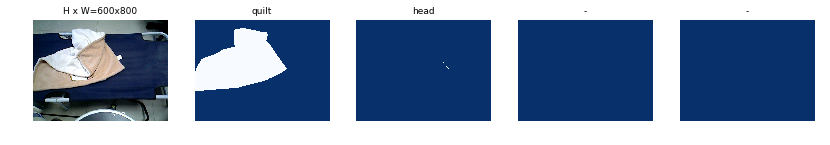

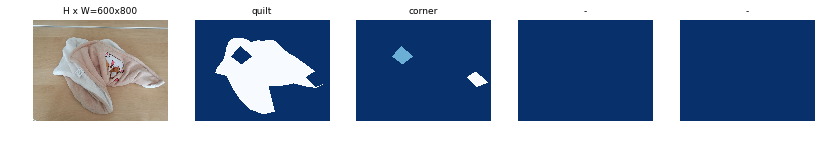

IndexError: index 3 is out of bounds for axis 2 with size 3

In [20]:
# Load and display random samples
import matplotlib.pyplot as plt
image_ids = np.random.choice(dataset_train.image_ids, 4)
# print(dataset_train.image_ids)

# print("which number of image been choosen :", image_ids)
for image_id in image_ids:
    # print(image_id)
    image = dataset_train.load_image(image_id)# -------- Image_ID is the label
    # image=image[height,width]
    # try:
    mask, class_ids = dataset_train.load_mask(image_id)
    # except:
    #     print(image_id)
    #     continue
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [64]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [88]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)
    


NameError: name 'model' is not defined

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [66]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

l=[2,3,4,5,6,7,8,9,10,33]
if image_id in l:
    continue
model.train(dataset_train, dataset_val, 
            learning_rate=0.1,#config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.1

Checkpoint Path: C:\Users\VCC\Desktop\Mask_RCNN-master\logs\shapes20181009T1951\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribut

D:\Annaconda\envs\tf-cpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10


KeyboardInterrupt: 

In [12]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: C:\Users\VCC\Desktop\Mask_RCNN-master\logs\shapes20181009T1458\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (C

Epoch 1/2


KeyboardInterrupt: 

In [13]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

KeyboardInterrupt: 

## Detection

In [11]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

original_image           shape: (128, 128, 3)         min:  108.00000  max:  236.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_bbox                  shape: (2, 5)                min:    2.00000  max:  102.00000
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000


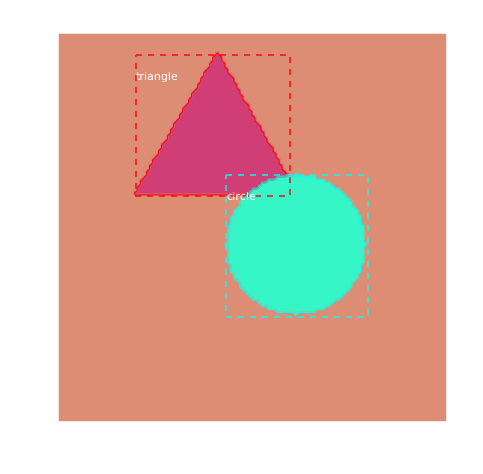

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:  108.00000  max:  236.00000
molded_images            shape: (1, 128, 128, 3)      min:  -15.70000  max:  132.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


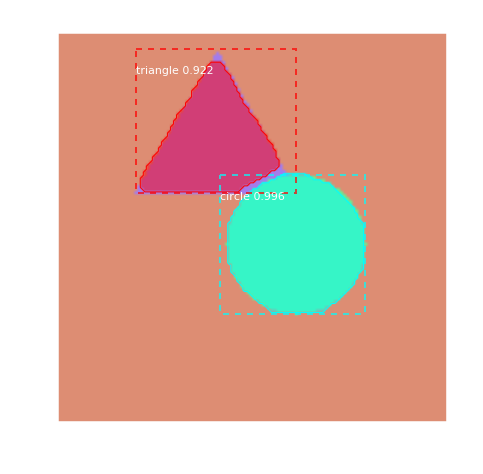

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95
